# Simple Variational Quantum Classifier On Jet model

20210209 First Edition

### Packages and data loading

1. Need to modify the "path" to run on Google Colab.
2. Set random seed (0) to reproduce the result.
3. Can load Iris data to see the performance of the model.

In [1]:
# !pip install pennylane autograd # install package for Google Colab
import os
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
np.random.seed(0)
# qml.about()

In [2]:
# path = "/content/drive/MyDrive/QML_project/jet_data" # path for Google Colab
path = os.getcwd()+"/jet_data" # path for local

def load_TJET_4var_data():
    print("-"*20)
    print("Start Loading data ...")
    x_train = torch.tensor(np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_X_train.npy"))
    y_train = torch.tensor(np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_Y_train.npy"))
    x_test = torch.tensor(np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_X_test.npy"))
    y_test = torch.tensor(np.load(path+"/VQC_TJET_4VAR_NO_TENSOR_Y_test.npy"))

    # Since y is {0,1} Change to {-1,1}
    y_train = 2*y_train-1
    y_val = 2*y_val-1
    y_test = 2*y_test-1

    # random choose part of train
    num_train = x_train.shape[0]
    random_pick = np.random.permutation(range(num_train))[:3000]
    x_train = x_train[random_pick]
    y_train = y_train[random_pick]

    print(f"x_train shape : {x_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"x_test shape : {x_test.shape}")
    print(f"y_test shape : {y_test.shape}")
    return x_train, y_train, x_test, y_test

def load_iris():
    print("-"*20)
    print("Start Loading data ...")
    iris_data = np.load(path+"/iris.npy")
    x = torch.tensor(iris_data[:, :-1])
    y = torch.tensor(iris_data[:, -1])
    # select train and test
    random_pick = np.random.permutation(range(x.shape[0]))
    num_train = int(0.75*x.shape[0])
    x, y = x[random_pick], y[random_pick]
    x_train, x_test = x[:num_train], x[num_train:]
    y_train, y_test = y[:num_train], y[num_train:]
    x_train, x_test = torch.tensor(x_train), torch.tensor(x_test)
    y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
    print(f"x_train shape : {x_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"x_test shape : {x_test.shape}")
    print(f"y_test shape : {y_test.shape}")
    return x_train, y_train, x_test, y_test

### VQC Circuit

The circuit define in this Simple VQC Model contains only layers, each layers contains only rotation gates and CNOT-gates.

<img src="meeting/20210209_Simple_VQC_model/my_circuit.png">

In [6]:
def variational_classifier(qnodes, params, feat):
    return qnodes(params[0], feat) + params[1]

def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

def circuit(weights, feat):
    qml.templates.embeddings.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def cost(qnodes, params, features, labels):
    loss = 0
    for i in range(len(labels)):
        loss += (variational_classifier(qnodes, params, features[i])-labels[i])**2
    loss = loss/len(labels)
    return loss

def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

### Start training

In this code, we set batch size with 10 and 60 epochs.

In order to run on pytorch, we need to set up Q-Node.

In [8]:
num_qubits = 0

def training(data, batch_size=10, total_iterations=60):
    # datas
    x_train, y_train = data[0], data[1]
    x_test, y_test = data[2], data[3]

    # setup quantum computer parameters
    global num_qubits
    num_qubits = int(np.ceil(np.log2(x_train.shape[1])))
    num_layers = 6
    print(f"qubits : {num_qubits} , layers : {num_layers}")
    dev = qml.device("default.qubit", wires=num_qubits)
    qnodes = qml.QNode(circuit, dev, interface="torch")

    # optimization setup
    lr_adam = 0.01
    num_train = x_train.shape[0]
    weights = Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
    bias = Variable(0.1 * torch.ones(1), requires_grad=True)
    params = (weights, bias)
    optimizer = optim.Adam(params, lr=lr_adam)

    # record all the result
    cost_list, acc_train_list, acc_test_list, params_list = [], [], [], []

    #start optimization
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        x_train_batch = x_train[batch_index]
        y_train_batch = y_train[batch_index]

        print("-"*20)
        print("Optimizing ...")
        optimizer.zero_grad()
        curr_cost = cost(qnodes,params, x_train_batch, y_train_batch)
        print("Backward ...")
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        print("Predicting ...")
        predictions_train = np.sign([variational_classifier(qnodes, params, feat) for feat in x_train])
        predictions_test = np.sign([variational_classifier(qnodes, params, feat) for feat in x_test])
        acc_train, acc_test = accuracy(y_train, predictions_train), accuracy(y_test, predictions_test)
        cost_list.append(curr_cost.item())
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        params_list.append(params)
        print(f"Iter: {it+1:5d} | Cost: {curr_cost.item():0.7f} | Acc train: {acc_train:0.7f} | Acc test: {acc_test:0.7f}")
    print("Training Finished ...")
    return_dic = {"cost":cost_list, "acc_train":acc_train_list, "acc_test":acc_test_list,
                  "params":params_list, "iterations":total_iterations, "batch":batch_size,
                  "train_size":(x_train.shape, y_train.shape), "test_size":(x_test.shape, y_test.shape)}
    return return_dic

In [ ]:
iris_result = training(load_iris(), batch_size=10, total_iterations=60)

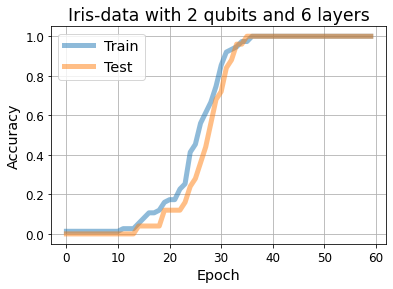

In [ ]:
# plot iris data

fig = plt.figure()
fig.set_facecolor('white')
plt.plot(range(iris_result["iterations"]), iris_result["acc_train"], lw=5, alpha=0.5, label="Train")
plt.plot(range(iris_result["iterations"]), iris_result["acc_test"], lw=5, alpha=0.5, label="Test")
plt.xlabel("Epoch", fontsize='x-large')
plt.ylabel("Accuracy", fontsize="x-large")

plt.grid()
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(fontsize='x-large')
plt.title('Iris-data with 2 qubits and 6 layers', fontsize='xx-large')
plt.show()

In [ ]:
TJET_4Var = training(load_TJET_4var_data(), batch_size=50, total_iterations=60)

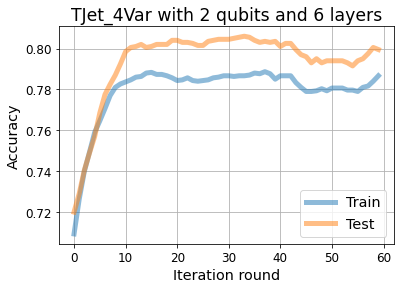

In [ ]:
# plot TJet data

fig = plt.figure()
fig.set_facecolor('white')
plt.plot(range(TJET_4Var["iterations"]), TJET_4Var["acc_train"], lw=5, alpha=0.5, label="Train")
plt.plot(range(TJET_4Var["iterations"]), TJET_4Var["acc_test"], lw=5, alpha=0.5, label="Test")
plt.xlabel("Epoch", fontsize='x-large')
plt.ylabel("Accuracy", fontsize="x-large")

plt.grid()
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(fontsize='x-large')
# plt.ylim(0.5,1)
plt.title('TJet_4Var with 2 qubits and 6 layers', fontsize='xx-large')
plt.show()